# Lab 2

breast-cancer.arff

*C4.5 decicion tree* vs *naive bayes classification*

In [34]:
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn import tree

In [35]:
data = arff.loadarff('breast-cancer.arff')
df = pd.DataFrame(data[0]).select_dtypes([np.object]).stack().str.decode('utf-8').unstack()
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [36]:
df.iloc[20:21,] # row with missing data

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
20,50-59,lt40,20-24,0-2,?,1,left,left_low,no,recurrence-events


In [37]:
df.index.size

286

In [38]:
df = df[(df['node-caps'] != '?') & (df['breast-quad'] != '?')]

In [39]:
df.index.size

277

In [40]:
df.shape

(277, 10)

In [41]:
cats = {}
codes, cats['age'] = pd.factorize(df['age'])
df.loc[:,'age'] = codes
codes, cats['menopause'] = pd.factorize(df['menopause'])
df.loc[:,'menopause'] = codes
codes, cats['tumor-size'] = pd.factorize(df['tumor-size'])
df.loc[:,'tumor-size'] = codes
codes, cats['inv-nodes'] = pd.factorize(df['inv-nodes'])
df.loc[:,'inv-nodes'] = codes
codes, cats['node-caps'] = pd.factorize(df['node-caps'])
df.loc[:,'node-caps'] = codes
codes, cats['breast'] = pd.factorize(df['breast'])
df.loc[:,'breast'] = codes
codes, cats['breast-quad'] = pd.factorize(df['breast-quad'])
df.loc[:,'breast-quad'] = codes
codes, cats['irradiat'] = pd.factorize(df['irradiat'])
df.loc[:,'irradiat'] = codes
codes, cats['Class'] = pd.factorize(df['Class'])
df.loc[:,'Class'] = codes


In [42]:
df.head()

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,0,0,0,0,0,3,0,0,0,0
1,1,1,0,0,1,1,0,1,0,1
2,1,1,1,0,1,2,1,2,0,0
3,0,0,1,0,0,3,0,2,1,1
4,0,0,2,1,0,2,1,3,0,0


In [43]:
Y = df['Class']
X = df.iloc[:,:-1]

In [45]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X, Y)

[Text(228.3440625, 210.192, 'X[5] <= 2.5\ngini = 0.414\nsamples = 277\nvalue = [81, 196]'),
 Text(163.738125, 195.696, 'X[3] <= 0.5\ngini = 0.307\nsamples = 195\nvalue = [37, 158]'),
 Text(117.29625, 181.2, 'X[7] <= 3.5\ngini = 0.269\nsamples = 162\nvalue = [26, 136]'),
 Text(113.57625, 166.704, 'X[1] <= 0.5\ngini = 0.293\nsamples = 146\nvalue = [26, 120]'),
 Text(76.4925, 152.208, 'X[2] <= 4.5\ngini = 0.361\nsamples = 76\nvalue = [18, 58]'),
 Text(48.825, 137.712, 'X[7] <= 0.5\ngini = 0.425\nsamples = 49\nvalue = [15, 34]'),
 Text(24.18, 123.216, 'X[0] <= 2.0\ngini = 0.469\nsamples = 16\nvalue = [6, 10]'),
 Text(14.88, 108.72, 'X[2] <= 1.5\ngini = 0.375\nsamples = 12\nvalue = [3, 9]'),
 Text(7.44, 94.22399999999999, 'X[0] <= 0.5\ngini = 0.444\nsamples = 3\nvalue = [2, 1]'),
 Text(3.72, 79.72799999999998, 'gini = 0.0\nsamples = 2\nvalue = [2, 0]'),
 Text(11.16, 79.72799999999998, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(22.32, 94.22399999999999, 'X[5] <= 1.5\ngini = 0.198\nsam

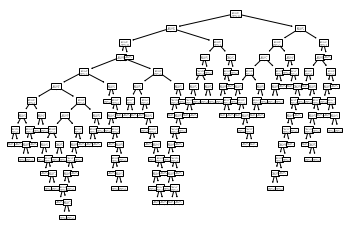

In [46]:
tree.plot_tree(clf)